In [1]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageOps

import ast

In [ ]:
!pip show torchvision

Name: torchvision
Version: 0.16.0+cu118
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, requests, torch
Required-by: fastai


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# TRAIN_MODE set to True if model already trained, False for inference
TRAIN_MODE = True

# Dataset Location
IMG_DIR_PATH = '/content/drive/MyDrive/Colab Notebooks/WaterMeters/images'
ANNOTATIONS_CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/WaterMeters/data.csv'
ANNOTATIONS_XLSX_PATH = '/content/drive/MyDrive/Colab Notebooks/WaterMeters/water_meters_markup.xlsx'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/OCR_WaterMeters/weights' #### TODO: put the right path when TRAIN_MODE = False

#Resize SIZE
SIZE = 400

# PYTORCH parameters
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 8
NB_EPOCHS = 8
NB_ITERATION = 1

In [4]:
#first create a dictionnary linking index to image name
# id values goes from 1 to 1244, I reframed that to have id from 0 to 1243.

INT_TO_NAME = {}
for dirname, _, filenames in os.walk(IMG_DIR_PATH):
    for filename in filenames:
        split = filename.split("_")
        INT_TO_NAME[int(split[1])-1] = filename
        # do it once for correct orientation of pictures
        # image = Image.open(os.path.join(IMG_DIR_PATH, filename))
        # image = ImageOps.exif_transpose(image)
        # image.save(os.path.join(IMG_DIR_PATH, filename))
        # image.close()

print('example: indice 2 file name -', INT_TO_NAME[1])
print('example: indice 1 file name -', INT_TO_NAME[0])

example: indice 2 file name - id_2_value_495_341.jpg
example: indice 1 file name - id_1_value_13_116.jpg


In [28]:
location_mine = pd.read_excel(ANNOTATIONS_XLSX_PATH)

In [29]:
location_mine.loc[location_mine['full'] == 2]

full  x_left_top  y_left_top  x_right_bot  y_right_bot  \
0        2        0.00        43.0       488.00       546.00   
1        2       99.00         0.0       619.00       487.00   
2        2       43.00       113.0       365.00       440.00   
3        2       39.00       149.0       287.00       402.00   
4        2       70.00       187.0       410.00       515.00   
...    ...         ...         ...          ...          ...   
1281     2        0.00        64.0       500.00       632.01   
1282     2       81.00       100.0       354.01       373.00   
1283     2        0.00       171.0       459.01       666.00   
1284     2      126.01       243.0       395.02       527.00   
1285     2       26.00       200.0       380.01       567.00   

                     photo_name  width  height  new_width  new_height  
0      id_864_value_456_239.jpg   1000    1333        500         666  
1     id_1129_value_143_703.jpg   1333    1000        666         500  
2        id_4_value_352_676.jpg   1000    1000        500         500  
3      id_359_value_257_642.jpg   1000    1778        333         593  
4       id_380_value_90_659.jpg   1000    1333        500         666  
...                         ...    ...     ...        ...         ...  
1281    id_47_value_301_107.jpg   1000    1333        500         666  
1282  id_1185_value_346_447.jpg   1000    1333        500         666  
1283   id_614_value_218_623.jpg   1000    1333        500         666  
1284   id_1022_value_95_735.jpg   1000    1333        500         666  
1285    id_837_value_55_481.jpg   1000    1333        500         666  

[1244 rows x 10 columns]

In [5]:
# location_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WaterMeters/data.csv').iloc[108,2]
location_test = pd.read_excel(ANNOTATIONS_XLSX_PATH).iloc[[108]]

def location_to_bounding_boxe(location, size):
    return [[int(round(a*size/ww, 0)), int(round(b*size/hh, 0)),
             int(round(c*size/ww, 0)), int(round(d*size/hh, 0))]
            for a, b, c, d, ww, hh in
            location[['x_left_top', 'y_left_top',
                      'x_right_bot', 'y_right_bot',
                      'new_width', 'new_height']].values
            ][0]
    # coordinate_list = ast.literal_eval(location)['data']
    # x_s = [pt['x']*size for pt in coordinate_list]
    # y_s = [pt['y']*size for pt in coordinate_list]
    # return max(min(x_s),0), min(min(y_s),size),  max(max(x_s),0), min(size,max(y_s))

print("the location:", location_test)
print("---")
print("the corresponding bounding boxe", location_to_bounding_boxe(location_test, 460))

the location:      full  x_left_top  y_left_top  x_right_bot  y_right_bot  \
108     2       177.0       220.0        386.0        433.0   

                   photo_name  width  height  new_width  new_height  
108  id_378_value_303_412.jpg   1000    1333        500         666  
---
the corresponding bounding boxe [163, 152, 355, 299]


In [6]:
transform_ = transforms.Compose([
        transforms.ToPILImage(),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize([SIZE,SIZE]),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#ResNet Normalization
    ])

class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None):
        self.img_labels = pd.read_excel(ANNOTATIONS_XLSX_PATH)
        self.img_labels = self.img_labels.loc[self.img_labels['full'] == 2].set_index('photo_name')
        self.img_dir = img_dir

        self.size = SIZE

        if transform:
            self.transform = transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        name = INT_TO_NAME[idx]
        img_path = os.path.join(self.img_dir, name)
        image = read_image(img_path)
        reading = 1 # self.img_labels.loc[name, 'value']
        bounding_boxe = location_to_bounding_boxe(self.img_labels.loc[[name]],
                                                  self.size)

        if self.transform:
            image = self.transform(image)

        return image, reading, torch.as_tensor(bounding_boxe, dtype=torch.float32)

In [8]:
location_test2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WaterMeters/data.csv').iloc[108,2]
location_test = pd.read_excel(ANNOTATIONS_XLSX_PATH).iloc[[108]]

def location_to_bounding_boxe(location, location2, size):
    res1 = [[int(round(a*w/ww, 0)), int(round(b*h/hh, 0)),
             int(round(c*w/ww, 0)), int(round(d*h/hh, 0))]
            for a, b, c, d, w, h, ww, hh in
            location[['x_left_top', 'y_left_top',
                      'x_right_bot', 'y_right_bot',
                      'width', 'height',
                      'new_width', 'new_height']].values
            ][0]
    ww, hh = location['width'].values[0], location['height'].values[0]
    coordinate_list = ast.literal_eval(location2)['data']
    x_s = [pt['x']*size for pt in coordinate_list]
    y_s = [pt['y']*size for pt in coordinate_list]
    res2 = max(min(x_s),0), min(min(y_s),size),  max(max(x_s),0), min(size,max(y_s))
    return res1, (res2[0]*ww/size, res2[1]*hh/size, res2[2]*ww/size, res2[3]*hh/size)

print("the location:", location_test)
print("---")
print("the corresponding bounding boxe", location_to_bounding_boxe(location_test, location_test2, 460))

the location:      full  x_left_top  y_left_top  x_right_bot  y_right_bot  \
108     2       177.0       220.0        386.0        433.0   

                   photo_name  width  height  new_width  new_height  
108  id_378_value_303_412.jpg   1000    1333        500         666  
---
the corresponding bounding boxe ([354, 440, 772, 867], (218.75, 361.97615, 805.9, 475.98764))


In [9]:
transform_ = transforms.Compose([
        transforms.ToPILImage(),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        # transforms.Resize([SIZE,SIZE]),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#ResNet Normalization
    ])

class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None):
        self.img_labels = pd.read_excel(ANNOTATIONS_XLSX_PATH)
        self.img_labels = self.img_labels.loc[self.img_labels['full'] == 2].set_index('photo_name')
        self.img_labels2 = pd.read_csv(annotations_file).set_index('photo_name')
        self.img_dir = img_dir

        self.size = SIZE

        if transform:
            self.transform = transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        name = INT_TO_NAME[idx]
        img_path = os.path.join(self.img_dir, name)
        image = read_image(img_path)
        reading = self.img_labels2.loc[name, 'value']
        bounding_boxe, bbox = location_to_bounding_boxe(self.img_labels.loc[[name]],
                                                        self.img_labels2.loc[name, 'location'],
                                                        self.size)

        if self.transform:
            image = self.transform(image)

        return name, image, reading, torch.as_tensor(bounding_boxe, dtype=torch.float32), torch.as_tensor(bbox, dtype=torch.float32)

In [7]:
import torch
from torchvision.utils import save_image
from torchvision.utils import draw_bounding_boxes
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

In [8]:
def show(imgs, vals):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(round(vals[i].item(), 3))
        # axs[0, i].set_title(vals)

In [9]:
waterMeterDataset = ImageDataset(ANNOTATIONS_CSV_PATH, IMG_DIR_PATH, transform = transform_)

In [46]:
loader = iter(waterMeterDataset)

In [47]:
locloc = location_mine.loc[location_mine['full'] == 2].set_index('photo_name')

In [33]:
locloc

full  x_left_top  y_left_top  x_right_bot  \
photo_name                                                             
id_864_value_456_239.jpg      2        0.00        43.0       488.00   
id_1129_value_143_703.jpg     2       99.00         0.0       619.00   
id_4_value_352_676.jpg        2       43.00       113.0       365.00   
id_359_value_257_642.jpg      2       39.00       149.0       287.00   
id_380_value_90_659.jpg       2       70.00       187.0       410.00   
...                         ...         ...         ...          ...   
id_47_value_301_107.jpg       2        0.00        64.0       500.00   
id_1185_value_346_447.jpg     2       81.00       100.0       354.01   
id_614_value_218_623.jpg      2        0.00       171.0       459.01   
id_1022_value_95_735.jpg      2      126.01       243.0       395.02   
id_837_value_55_481.jpg       2       26.00       200.0       380.01   

                           y_right_bot  width  height  new_width  new_height  
photo_name                                                                    
id_864_value_456_239.jpg        546.00   1000    1333        500         666  
id_1129_value_143_703.jpg       487.00   1333    1000        666         500  
id_4_value_352_676.jpg          440.00   1000    1000        500         500  
id_359_value_257_642.jpg        402.00   1000    1778        333         593  
id_380_value_90_659.jpg         515.00   1000    1333        500         666  
...                                ...    ...     ...        ...         ...  
id_47_value_301_107.jpg         632.01   1000    1333        500         666  
id_1185_value_346_447.jpg       373.00   1000    1333        500         666  
id_614_value_218_623.jpg        666.00   1000    1333        500         666  
id_1022_value_95_735.jpg        527.00   1000    1333        500         666  
id_837_value_55_481.jpg         567.00   1000    1333        500         666  

[1244 rows x 9 columns]

In [48]:
while loader:
  name, img, _, bbox, bbox2 = next(loader)
  img = img[:, int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
  ww, hh = bbox2[2] - bbox2[0], bbox2[3] - bbox2[1]
  bbox2[0], bbox2[1] = bbox2[0] - bbox[0], bbox2[1] - bbox[1]
  bbox2[2], bbox2[3] = bbox2[0] + ww, bbox2[1] + hh
  locloc.loc[name, 'x_left_top'] = bbox2[0].item()
  locloc.loc[name, 'y_left_top'] = bbox2[1].item()
  locloc.loc[name, 'x_right_bot'] = bbox2[2].item()
  locloc.loc[name, 'y_right_bot'] = bbox2[3].item()
# save_image(img, '/content/drive/MyDrive/Colab Notebooks/WaterMetersSquared/' + name)

KeyError: ignored

In [49]:
locloc.to_csv('/content/drive/MyDrive/Colab Notebooks/WaterMetersSquared/data.csv')

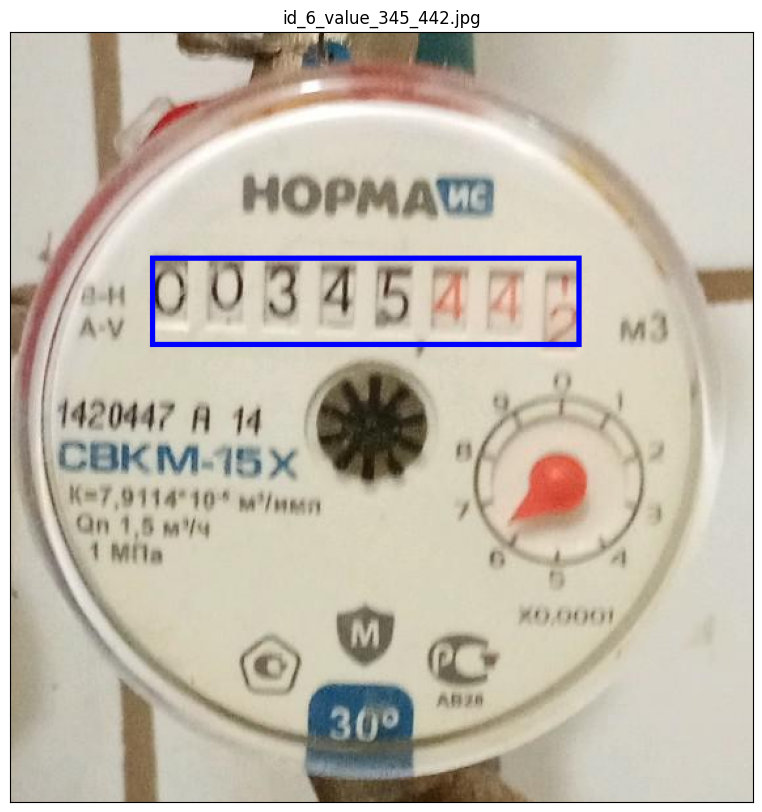

In [27]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (10, 10)

img = (img.cpu()*255).type(torch.uint8)
images = [
    draw_bounding_boxes(image, boxes=boxe.unsqueeze(0), width=4, colors=['blue'])
    for image, boxe in zip(img.unsqueeze(0),
                           bbox2.unsqueeze(0))
]
show(images, name)

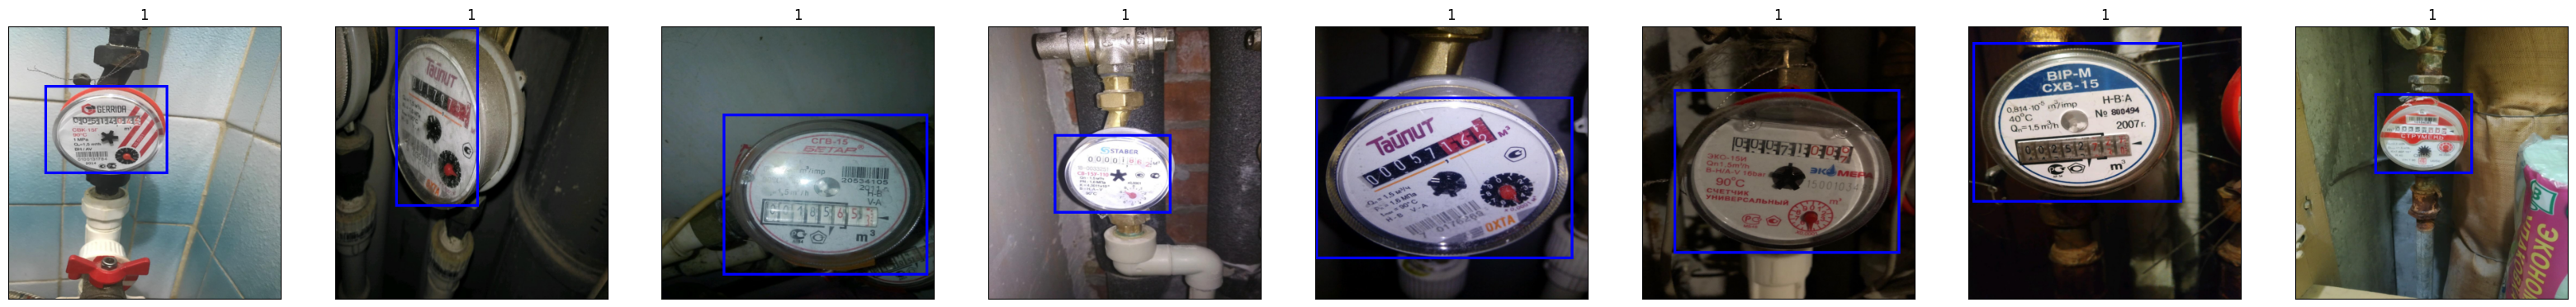

In [10]:
from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (40, 100)

loader = DataLoader(waterMeterDataset, batch_size=8, shuffle=True)
img, values, bounding_boxes  = next(iter(loader))
img = (img.cpu()*255).type(torch.uint8)
images = [
    draw_bounding_boxes(image, boxes=boxe.unsqueeze(0), width=4, colors=['blue'])
    for image, boxe in zip(img, bounding_boxes)
]
show(images, values)

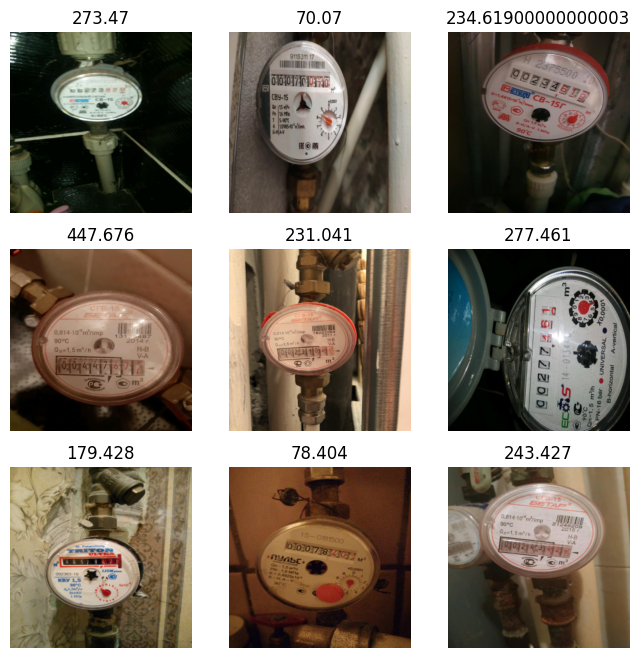

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(waterMeterDataset), size=(1,)).item()
    img, reading, bounding_boxe = waterMeterDataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(reading)
    plt.axis("off")
    plt.imshow(img.squeeze().transpose(0,1).transpose(1,2), cmap="gray")
plt.show()

In [11]:
train_size = int(0.9*len(waterMeterDataset))

In [12]:
def give_model():
    model = fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers = 1)
    num_classes = 2  # 1 class (watermeter) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [13]:
# adapted from https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/
def train(train_dataloader, model, optimizer):
    print('Training')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_dataloader, total=len(train_dataloader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        batch, _, bounding_boxes = data

        batch = list(image.to(DEVICE) for image in batch)

        #the faster R_CNN model takes as targets a list of dictionnary with boxe and label
        targets = [{'boxes': bounding_boxe.unsqueeze(0).to(DEVICE),
                    'labels': torch.ones(1, dtype = torch.int64).to(DEVICE)} for bounding_boxe in bounding_boxes]
        #it returns during training a dict containing the classification and regression losses.
        loss_dict = model(batch, targets)
        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()

        train_loss_list.append(loss_value)

        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return train_loss_list

def validate(test_dataloader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(test_dataloader, total=len(test_dataloader))

    for i, data in enumerate(prog_bar):
        batch, _, bounding_boxes = data

        batch = list(image.to(DEVICE) for image in batch)
        #the faster R_CNN model takes as targets a list of dictionnary with boxe and label
        targets = [{'boxes': bounding_boxe.unsqueeze(0).to(DEVICE), 'labels': torch.ones(1, dtype = torch.int64).to(DEVICE)} for bounding_boxe in bounding_boxes]

        with torch.no_grad():
            loss_dict = model(batch, targets)
        #it returns during training a dict containing the classification and regression losses.
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        val_loss_list.append(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
import time

plt.rcParams["figure.figsize"] = (5,5)

if TRAIN_MODE:
    train_set, val_set = torch.utils.data.random_split(waterMeterDataset,
     [train_size, len(waterMeterDataset) - train_size])
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    # model = give_model()
    # model = model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]

    # define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.8, weight_decay=0.0005)

    train_itr = 1
    val_itr = 1
    train_loss_list = []
    val_loss_list = []

    # name to save the trained model with
    MODEL_NAME = 'water_meters_model'

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start the training epochs
    for epoch in range(NB_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NB_EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()

        train_loss = train(train_dataloader, model, optimizer)
        val_loss = validate(test_dataloader, model)

        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

    torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/OCR_WaterMeters/weights/' + MODEL_NAME + '_upd.pth')
    print('SAVING MODEL COMPLETE...\n')

    train_ax.plot(train_loss_list, color='blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss_list, color='red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    plt.show()

In [23]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/OCR_WaterMeters/weights/' + MODEL_NAME + '_upd.pth')
print('SAVING MODEL COMPLETE...\n')

SAVING MODEL COMPLETE...



In [16]:
model = give_model()
model = model.to(DEVICE)

In [17]:
import numpy as np
import cv2

# if not TRAIN_MODE:
model.load_state_dict(torch.load(
    '/content/drive/MyDrive/Colab Notebooks/OCR_WaterMeters/weights/' + 'water_meters_detection' + '.pth', map_location=DEVICE))

model = model.to(DEVICE)
# model.eval()
# print('set model to evaluation mode')

In [18]:
from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

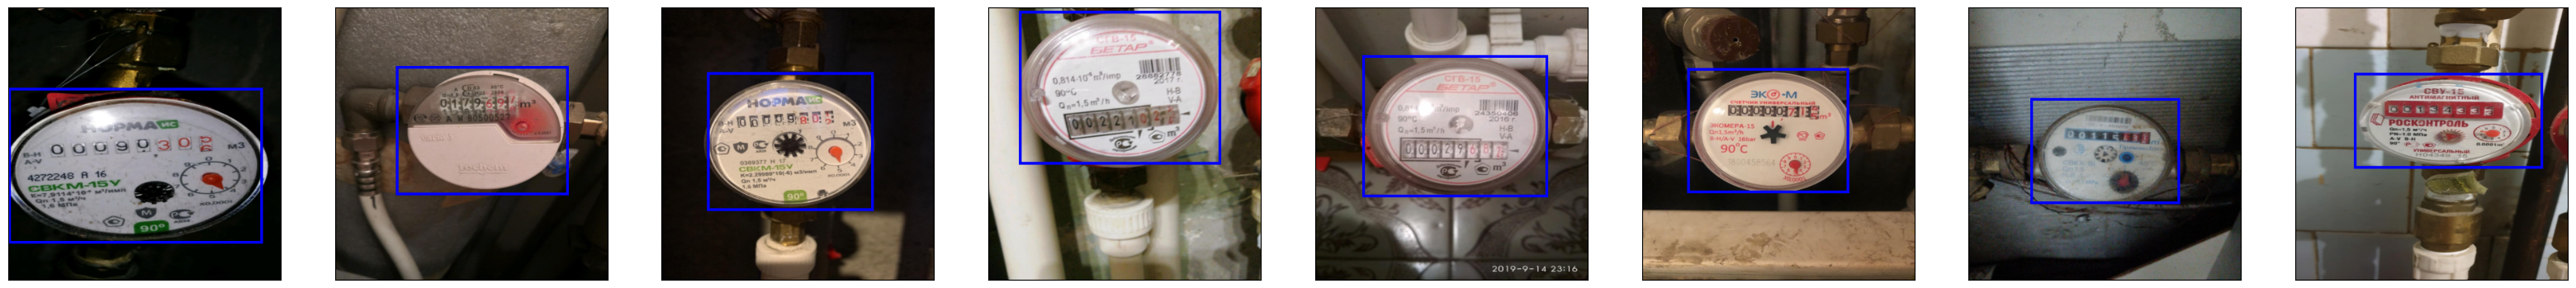

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (40, 100)

detection_threshold = 0.05


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

loader = DataLoader(waterMeterDataset, batch_size=8, shuffle=True)
img, _, bounding_boxes  = next(iter(loader))
img = img.to(DEVICE)

model.eval()
with torch.no_grad():
    outputs = model(img)

img = (img.cpu()*255).type(torch.uint8)
#images = img.cpu().data.numpy()
#load next operations to cpu
#outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
images = [
    #draw_bounding_boxes(image, boxes=output['boxes'][output['scores'] > detection_threshold], width=4, colors=['blue'])
    draw_bounding_boxes(image, boxes=output['boxes'][[0]], width=4, colors=['blue'])
    for image, output in zip(img, outputs)
]
show(images)

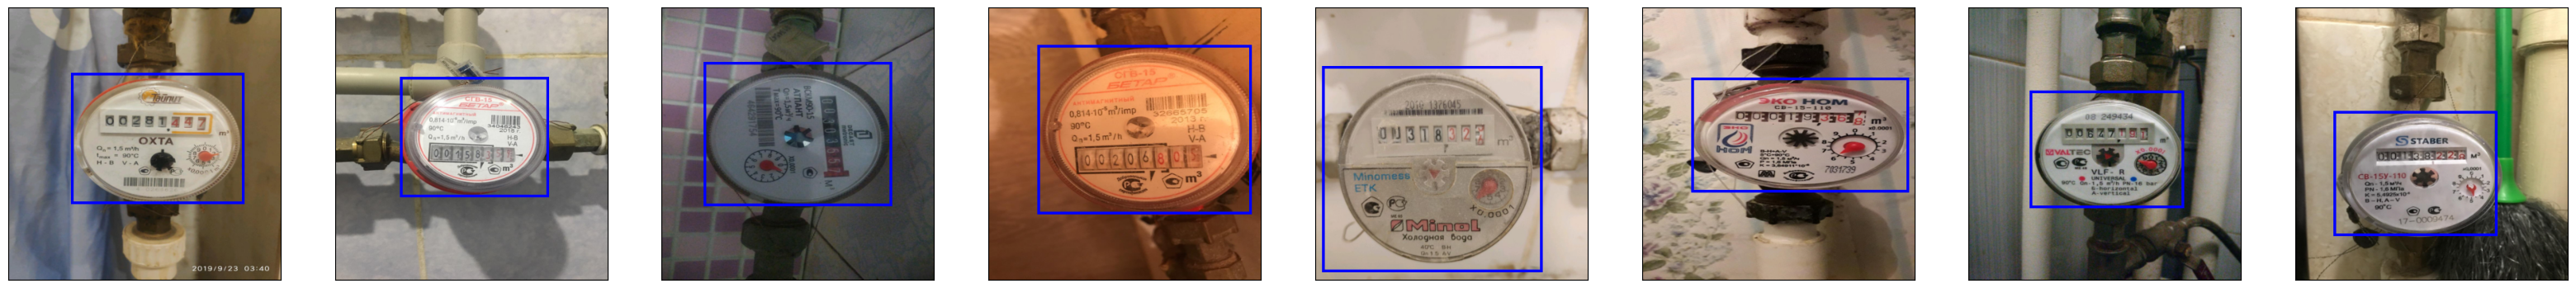

In [22]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (40, 100)

detection_threshold = 0.05


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#loader = DataLoader(waterMeterDataset, batch_size=8, shuffle=True)
img, _, bounding_boxes  = next(iter(test_dataloader))
img = img.to(DEVICE)

model.eval()
with torch.no_grad():
    outputs = model(img)

img = (img.cpu()*255).type(torch.uint8)
#images = img.cpu().data.numpy()
#load next operations to cpu
#outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
images = [
    #draw_bounding_boxes(image, boxes=output['boxes'][output['scores'] > detection_threshold], width=4, colors=['blue'])
    draw_bounding_boxes(image, boxes=output['boxes'][[0]], width=4, colors=['blue'])
    for image, output in zip(img, outputs)
]
show(images)

In [ ]:
img_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Pics/IMG_20230208_160954.jpg')
#img_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Pics/IMG_20230301_123204.jpg')
#img_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Pics/IMG_20230301_123225.jpg')
image = read_image(img_path)

In [ ]:
image.shape

In [ ]:
transform_2 = transforms.Compose([
        transforms.ToPILImage(),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize([SIZE,SIZE]),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#ResNet Normalization
    ])

In [ ]:
image = transform_2(image).to(DEVICE)

model.eval()
with torch.no_grad():
    output2 = model(image.unsqueeze(0))

In [ ]:
img = (image.unsqueeze(0).cpu()*255).type(torch.uint8)

In [ ]:
img.shape

torch.Size([1, 3, 400, 400])

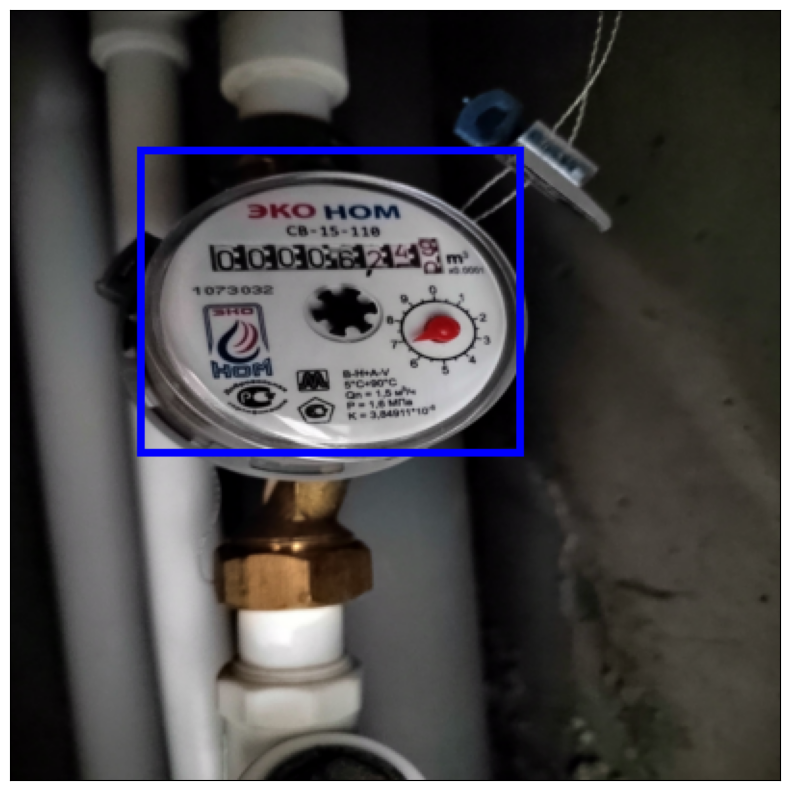

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (10, 10)

images = [
    draw_bounding_boxes(image, boxes=outp['boxes'][[0]], width=3, colors=['blue'])
    for image, outp in zip(img, output2)
]
show(images)